# Assignment 5

#### -Install libraries if necessary

In [1]:
##!pip install geopandas

In [2]:
##!pip install contextily

In [3]:
##!pip install libpysal
##!pip install pysal

#### - Import libraries

In [4]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN  
from esda.moran import Moran
from splot.esda import moran_scatterplot
from pysal.model import spreg

In [7]:
import contextily as ctx

### Load Shapefile, print and plot to check

In [8]:
shp_path = "cb_2018_us_county_500k.shp"
gdf_counties = gpd.read_file(shp_path)

print(gdf_counties.head())
print(gdf_counties.crs)  
print(gdf_counties.describe())

  STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME LSAD       ALAND  \
0      21      007  00516850  0500000US21007  21007  Ballard   06   639387454   
1      21      017  00516855  0500000US21017  21017  Bourbon   06   750439351   
2      21      031  00516862  0500000US21031  21031   Butler   06  1103571974   
3      21      065  00516879  0500000US21065  21065   Estill   06   655509930   
4      21      069  00516881  0500000US21069  21069  Fleming   06   902727151   

     AWATER                                           geometry  
0  69473325  POLYGON ((-89.18137 37.0463, -89.17938 37.0530...  
1   4829777  POLYGON ((-84.44266 38.28324, -84.44114 38.283...  
2  13943044  POLYGON ((-86.94486 37.07341, -86.94346 37.074...  
3   6516335  POLYGON ((-84.12662 37.6454, -84.12483 37.6461...  
4   7182793  POLYGON ((-83.98428 38.44549, -83.98246 38.450...  
EPSG:4269
              ALAND        AWATER
count  3.233000e+03  3.233000e+03
mean   2.833238e+09  2.160727e+08
std    9.23

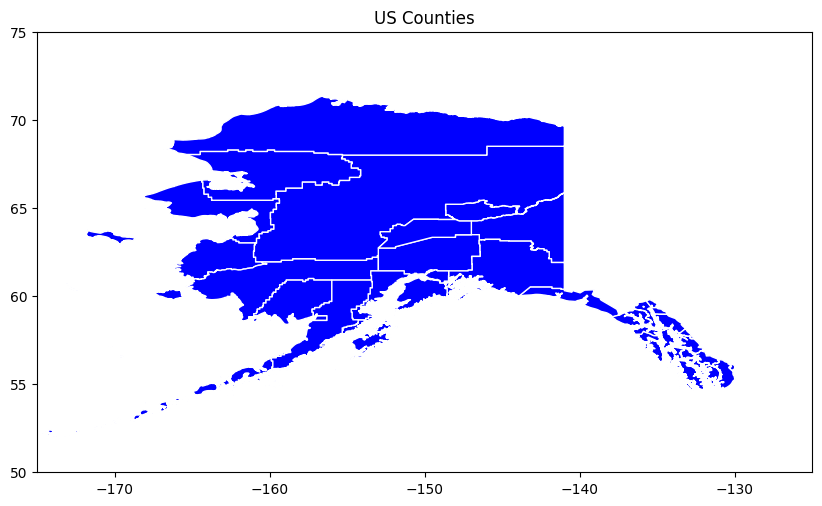

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
gdf_counties.plot(ax=ax, color="blue", edgecolor="white")
ax.set_title("US Counties")
plt.xlim(-175, -125)
plt.ylim(50, 75)
plt.show()

### Load income data

In [10]:
csv_path = "ACSST5Y2020.S1901-Data.csv"
df_data = pd.read_csv(csv_path, skiprows=1)

print(df_data.head())
print(df_data.describe())


        Geography     Geographic Area Name  Estimate!!Households!!Total  \
0  0500000US01001  Autauga County, Alabama                        21559   
1  0500000US01003  Baldwin County, Alabama                        84047   
2  0500000US01005  Barbour County, Alabama                         9322   
3  0500000US01007     Bibb County, Alabama                         7259   
4  0500000US01009   Blount County, Alabama                        21205   

   Margin of Error!!Households!!Total  \
0                                 366   
1                                1143   
2                                 338   
3                                 299   
4                                 430   

   Estimate!!Households!!Total!!Less than $10,000  \
0                                             6.2   
1                                             5.2   
2                                            14.6   
3                                            11.0   
4                                    

In [11]:
gdf_counties['AFFGEOID']

0       0500000US21007
1       0500000US21017
2       0500000US21031
3       0500000US21065
4       0500000US21069
             ...      
3228    0500000US31073
3229    0500000US39075
3230    0500000US48171
3231    0500000US55079
3232    0500000US26139
Name: AFFGEOID, Length: 3233, dtype: object

### Merge tables

In [12]:
gdf_merged = gdf_counties.merge(df_data, 
                                left_on="AFFGEOID", 
                                right_on="Geography",
                                how="inner")
variable = "Estimate!!Nonfamily households!!Mean income (dollars)" 
import numpy as np

gdf_merged[variable] = gdf_merged[variable].replace("N", np.nan)
gdf_merged[variable] = gdf_merged[variable].dropna()
gdf_merged[variable] = gdf_merged[variable].astype(float)
gdf_merged = gdf_merged.drop(208) #### Somehow dropna misses this column that caused lots of problems to identify the issue

In [13]:
print(gdf_merged.describe())

              ALAND        AWATER  Estimate!!Households!!Total  \
count  3.218000e+03  3.218000e+03                 3.218000e+03   
mean   2.817242e+09  2.091697e+08                 3.839542e+04   
std    9.135475e+09  1.189887e+09                 1.167937e+05   
min    5.300265e+06  0.000000e+00                 6.200000e+01   
25%    1.085166e+09  7.007746e+06                 4.379750e+03   
50%    1.565575e+09  1.934524e+07                 1.006800e+04   
75%    2.368401e+09  6.051552e+07                 2.592475e+04   
max    3.770347e+11  2.599228e+10                 3.332504e+06   

       Margin of Error!!Households!!Total  \
count                         3218.000000   
mean                           405.289932   
std                            375.302074   
min                             26.000000   
25%                            191.000000   
50%                            304.000000   
75%                            486.000000   
max                           5051.000000   


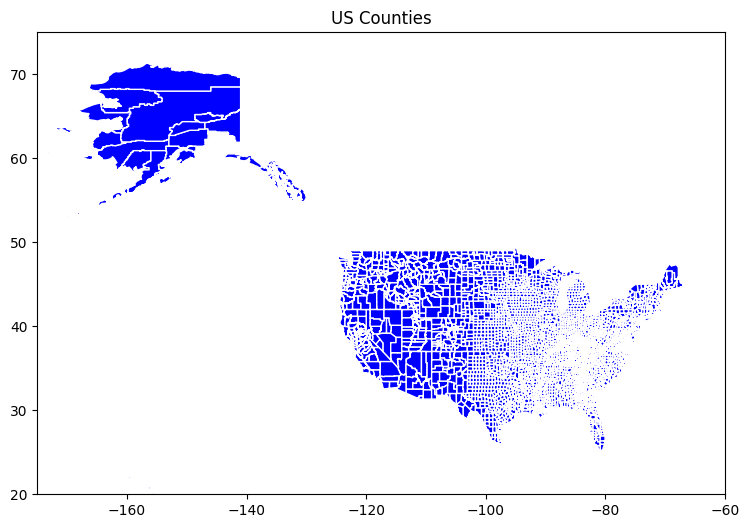

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
gdf_merged.plot(ax=ax, color="blue", edgecolor="white")
ax.set_title("US Counties")
plt.xlim(-175, -60)
plt.ylim(20, 75)
plt.show()

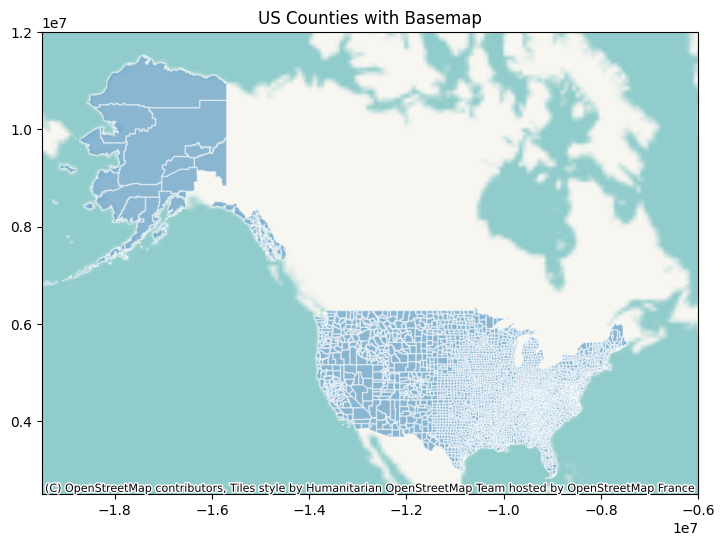

In [15]:
gdf_3857 = gdf_merged.to_crs(epsg=3857)  # Convert to web-mercator
fig, ax = plt.subplots(figsize=(10, 6))
gdf_3857.plot(ax=ax, alpha=0.5, edgecolor="white")
ctx.add_basemap(ax)  # Add basemap from contextily
ax.set_title("US Counties with Basemap")
plt.xlim(-1.95 * 1e7, -0.6 * 1e7)
plt.ylim(0.25 * 1e7, 1.2 * 1e7)
plt.show()

## 2. Creating spatial weights

In [16]:
# w_queen = Queen.from_dataframe(gdf_merged)
#w_rook = Rook.from_dataframe(gdf_merged)


w_knn = KNN.from_dataframe(gdf_merged, k=4)
w_knn.transform = 'R'

/kuacc/users/mkizil19/hpc_run/flaxenv/lib/python3.9/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  warnings.warn(message)


## 3. Spatial Autocorrelation


#### Moran's I measures the degree to which a variable is spatially clustered (positive autocorrelation), randomly distributed (near zero), or dispersed (negative autocorrelation).
####	•	A value of 0.613 indicates a strong positive spatial autocorrelation (similar values cluster in nearby locations).
####	•	A p-value of 0.001 suggests this clustering pattern is statistically significant (very unlikely to be random).

In [17]:
#print(gdf_merged[variable].describe())

y = gdf_merged[variable].values


moran = Moran(y, w_knn)
print(f"\n\n\nMoran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")




Moran's I: 0.6131431604241862
p-value: 0.001


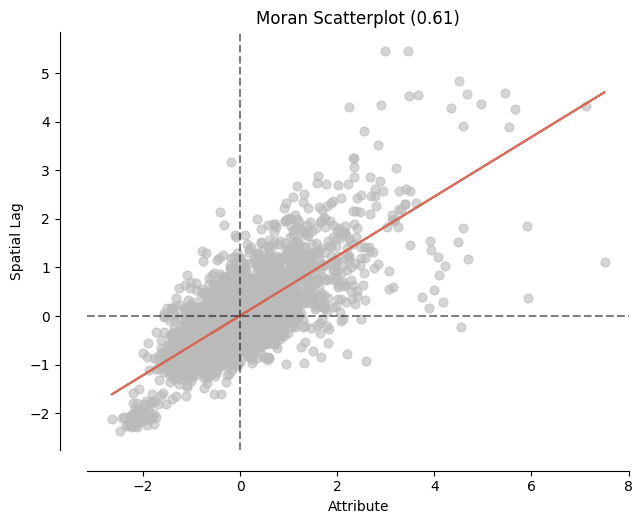

In [18]:
fig, ax = moran_scatterplot(moran)
plt.show()

## 4. Spatial Regression

##### Unfortunately, I couldn't get meaningful columns for this task as original table only included about income variables. I used ALAND and AWATER from shapefile which seems to had no correlation between income as expected, and also mean income for households which has high correlation with general mean income as expected.

In [22]:
X_cols = ["ALAND", "AWATER", "Estimate!!Households!!Mean income (dollars)"]


y = gdf_merged[[variable]].values
X = gdf_merged[X_cols].values

X = np.column_stack((np.ones(X.shape[0]), X))  

w_full = w_knn.full()[0]

# Spatial Lag Model
lag_model = spreg.ML_Lag(
    y, 
    X, 
    w_knn, 
    name_y=variable,
    name_x=["Constant"] + X_cols, 
    name_w="knn", 
    name_ds="US Counties"
)

print(lag_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            : US Counties
Weights matrix      :         knn
Dependent Variable  :Estimate!!Nonfamily households!!Mean income (dollars)                Number of Observations:        3218
Mean dependent var  :  43173.1287                Number of Variables   :           5
S.D. dependent var  :  13153.5041                Degrees of Freedom    :        3213
Pseudo R-squared    :      0.8013
Spatial Pseudo R-squared:  0.7971
Log likelihood      : -32496.3082
Sigma-square ML     :34373744.6182                Akaike info criterion :   65002.616
S.E of regression   :   5862.9126                Schwarz criterion     :   65032.999

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------

## 5. Visualization

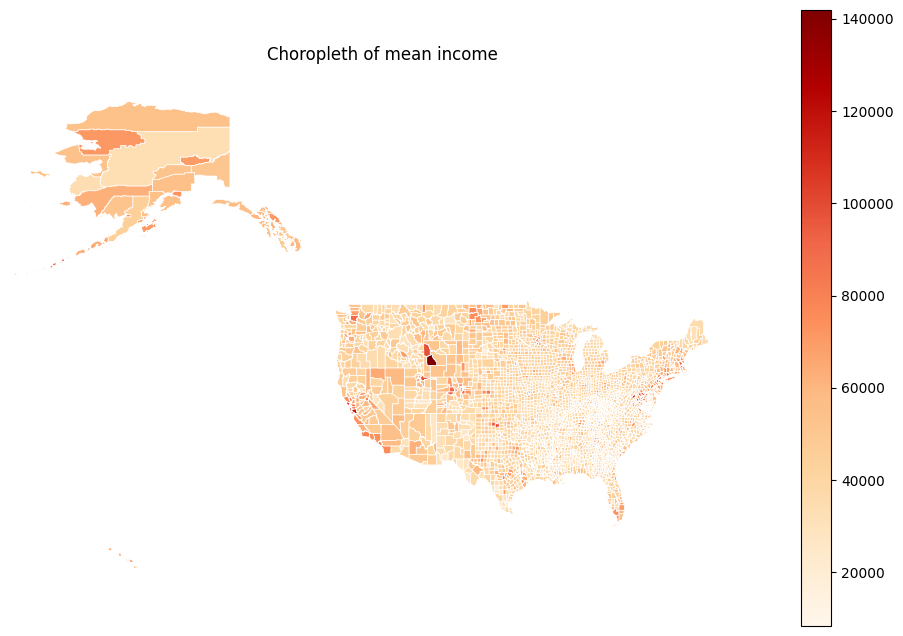

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf_merged.plot(column=variable, 
                cmap='OrRd', 
                legend=True, 
                edgecolor='white', 
                linewidth=0.5, 
                ax=ax)
ax.set_title(f"Choropleth of mean income")
ax.axis('off')
plt.xlim(-175, -60)
plt.ylim(20, 75)
plt.show()